In [59]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Initial required libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Loading the Dataset
*About the data:* <br>
The data is an twitter comments of various US Airlines having sentiments of the tweet: positive, negative or neutral.

*Columns:* <br>


1.   text: The actual tweet
2.   airline: Name of the airline tweeted about
3. latitude, longitude: Location of the tweet
4. airline_sentiment_confidence : Confidence of the sentiment classification of the tweet
5. airline_sentiment: Sentiment of the tweet


In [136]:
#intializing global variables
data = pd.read_csv('https://raw.githubusercontent.com/anjaliasha123/Data_Visualization_projects/master/Streamlit_python/Tweets.csv')
print(data.text.head(2))
print(data.shape)
print(data.airline_sentiment.value_counts())
num_of_categories = 2363
data = data.reindex(np.random.permutation(data.index))
positive = data[data['airline_sentiment'] == 'positive'][:num_of_categories]
negative = data[data['airline_sentiment'] == 'negative'][:num_of_categories]
neutral = data[data['airline_sentiment'] == 'neutral'][:num_of_categories]
data = pd.concat([positive,negative,neutral], ignore_index=True)
data = data.reindex(np.random.permutation(data.index))
print(data.shape)

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
Name: text, dtype: object
(14640, 12)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
(7089, 12)


#Splitting the data into train and test set

In [11]:
data.shape

(7089, 12)

In [12]:
train_data = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]
print(train_data.shape)
print(test_data.shape)

(5671, 12)
(1418, 12)


In [14]:
#storing test data for future
test_data.to_csv('test.csv')

For the purpose of this project, we are considering only the 'text' column of the Xdata

#MOST COMMON VARIABLES:


*   most_common : for the most common words of the dictionary
*   max_len : maximum length of the sequence to be truncated into
* epochs : Number of times the training of the model must be done. It is a value that determines when a model should stop its training explicitly.
* embed_dim : Dimension of a word vector
* batch_size : size of a batch to train during each itteration of model training


In [15]:
most_common = 20000 
max_len = 100 
epochs = 10
embed_dim = 100
batch_size = 100

#Data Preprocessing



*   We need to convert y labels into categorical values
*   We need to convert the 



In [17]:
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

2091    0
6083    2
130     0
4575    1
347     0
235     0
5974    2
5894    2
4790    2
6463    2
Name: LABEL, dtype: int64


In [137]:
data['LABEL'] = 0
data.loc[data.airline_sentiment == 'positive', 'LABEL'] = 0
data.loc[data.airline_sentiment == 'negative', 'LABEL'] = 1
data.loc[data.airline_sentiment == 'neutral', 'LABEL'] = 2
print(data['LABEL'][:10])

4537    1
2298    0
4190    1
3908    1
3411    1
5670    2
4733    2
5263    2
4545    1
1229    0
Name: LABEL, dtype: int64


In [138]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [142]:
pX, size_unique_wordsX, wordIndex,tok = dataPreprocessing(most_common,data,'text')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pX , labels, test_size=0.2)

Found 10437 unique tokens.


In [18]:
from tensorflow.keras.utils import to_categorical
labels = to_categorical(data['LABEL'], num_classes=3)
print(labels[:10])

[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


#Preprocessing the Tweets


*   Removing the name of the airlines @airlinename from the tweets
*   Replacing abbrieviations from the tweets
*   Removing meaningless stopwords
*   Converting texts into lowercase



In [34]:
X = train_data['text'].to_frame()
X.head(2)

,text
2091,"@JetBlue marks 15th year with new ""Bluemanity""..."
6083,@SouthwestAir @Imaginedragons when are we gonn...


In [33]:
import re
from tqdm import tqdm
def preProcessTweets(X,colName):
  X[colName] = X[colName].str.replace('@VirginAmerica','')
  X[colName] = X[colName].str.replace('@united','')
  X[colName] = X[colName].str.replace('@SouthwestAir','')
  X[colName] = X[colName].str.replace('@JetBlue','')
  X[colName] = X[colName].str.replace('@AmericanAir','')
  X[colName] = X[colName].str.replace('@USAirways','')
  #stopwords
  # https://gist.github.com/sebleier/554280
  stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
              "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
              'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
              'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
              'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
              'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
              'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
              'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
              'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
              'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
              's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
              've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
              "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
              "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
              'won', "won't", 'wouldn', "wouldn't"]
  #replacing abbreiviations
  def removeAbbrieves(text):
    text = re.sub(r"won't","will not",text)
    text = re.sub(r"can\'t", "can not",text)
    text = re.sub(r"n\'t", " not", text)
    text= re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have",text)
    text = re.sub(r"\'m", " am", text)
    return text
  #combining all
  preprocessed_text = []
  for sentence in tqdm(X[colName].values):
      sent = removeAbbrieves(sentence)
      sent = sent.replace('\\r', ' ')
      sent = sent.replace('\\n', ' ')
      sent = sent.replace('\\"', ' ')
      sent = sent.replace('http"', ' ')
      sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
      sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
      preprocessed_text.append(sent.lower().strip())
  return preprocessed_text

  



In [35]:
X['text'] = preProcessTweets(X,'text')
X.head(2)

100%|██████████| 5671/5671 [00:00<00:00, 15645.51it/s]


,text
2091,marks 15th year new bluemanity plane design su...
6083,imaginedragons gonna know math test tomoro not...


In [41]:
train_data['processedText'] = X['text']
train_data[['text','processedText','airline_sentiment']].head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,processedText,airline_sentiment
2091,"@JetBlue marks 15th year with new ""Bluemanity""...",marks 15th year new bluemanity plane design su...,positive
6083,@SouthwestAir @Imaginedragons when are we gonn...,imaginedragons gonna know math test tomoro not...,neutral


#Word Clouds

In [47]:
positiveTweets = " ".join(train_data[train_data.airline_sentiment == 'positive'].processedText.values)
negativeTweets = " ".join(train_data[train_data.airline_sentiment == 'negative'].processedText.values)
neutralTweets = " ".join(train_data[train_data.airline_sentiment == 'neutral'].processedText.values)

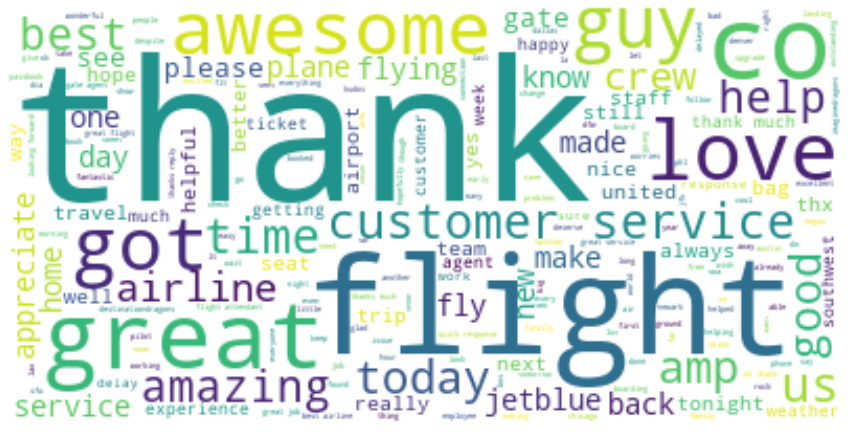

In [54]:
from wordcloud import WordCloud 
wordcloud = WordCloud(background_color="white").generate(positiveTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

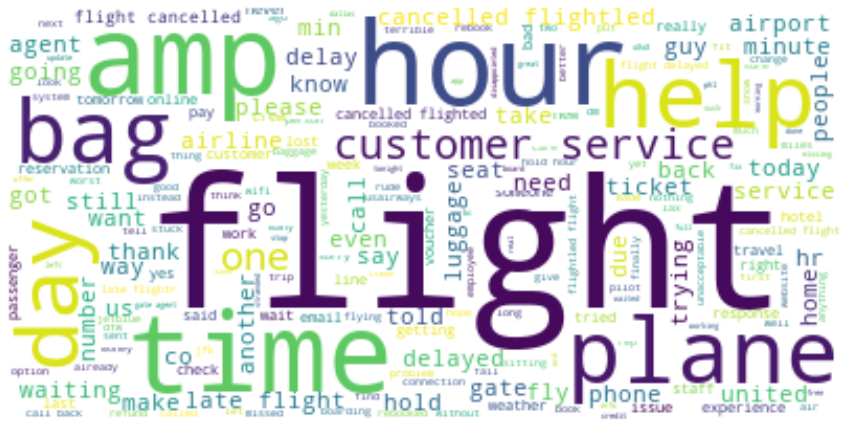

In [53]:
wordcloud = WordCloud(background_color="white").generate(negativeTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

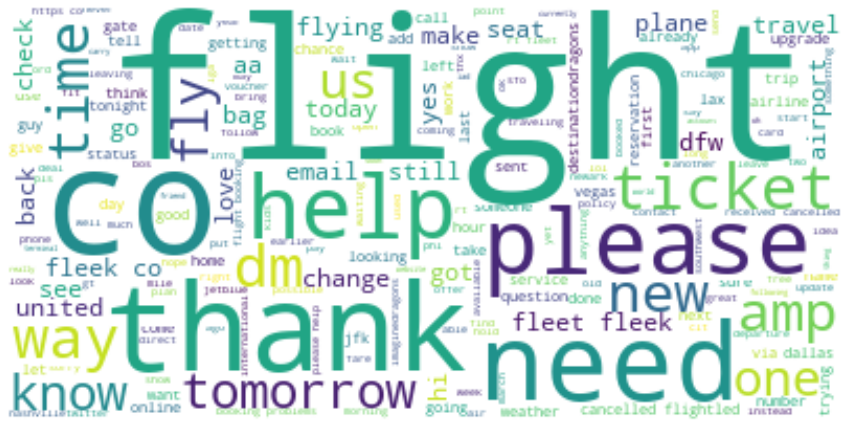

In [52]:
wordcloud = WordCloud(background_color="white").generate(neutralTweets)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Approaching towards Deep learning Model


*   dataPreprocessing() : to convert pre-processed tweets into tokens and then created into padded sequences of the word indexes
*   List item



In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def dataPreprocessing(most_common,X,colName):

  tok = Tokenizer(num_words = most_common,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
  tok.fit_on_texts(X[colName].values)
  sequences = tok.texts_to_sequences(X[colName].values)
  word_index = tok.word_index
  print('Found %s unique tokens.' % len(word_index))
  paddedX = pad_sequences(sequences, maxlen = max_len,padding='post')
  return paddedX, len(word_index), word_index,tok

pX, size_unique_wordsX, wordIndex,tok = dataPreprocessing(most_common,train_data,'processedText')

Found 8651 unique tokens.


In [57]:
pX

array([[1537, 1538,  286, ...,    0,    0,    0],
       [ 259,  869,   39, ...,    0,    0,    0],
       [ 122, 3536,   15, ...,    0,    0,    0],
       ...,
       [ 425, 1859, 8648, ...,    0,    0,    0],
       [8650,    8,  261, ...,    0,    0,    0],
       [8651,    7,  726, ...,    0,    0,    0]], dtype=int32)

#Creating the WordToVector dictionary

In [60]:
def createEmbeddingMatrix(word_index):
  word2vec = {}
  with open(os.path.join('/content/gdrive/My Drive/glove.6B.100d.txt'),encoding='utf8') as f:
      for line in f:
          values = line.rstrip().rsplit(' ')
          word = values[0]
          coefs = np.asarray(values[1:], dtype='float32')
          word2vec[word] = coefs
  num_of_words = min(most_common, len(word_index)+1)
  embedding_matrix = np.zeros((num_of_words,embed_dim))
  for word,i in word_index.items():
      if i < num_of_words:
          embedd_vec = word2vec.get(word)
          if embedd_vec is not None:
              embedding_matrix[i] = embedd_vec
  return embedding_matrix, num_of_words

embedMatrix, num_of_words = createEmbeddingMatrix(wordIndex)

In [61]:
embedMatrix.shape

(8652, 100)

#Creating the Model

In [62]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import  Adam

In [67]:
#creating the embedding layer
embedding_layer = Embedding(input_dim=num_of_words,output_dim=max_len,weights=[embedMatrix],input_length=max_len,trainable=False)
#input_layer
input_layer = Input((max_len,),name='InputLayer')
#embedding layer
embedding_layer = embedding_layer(input_layer)
#bi-directional LSTM layer
lstm = Bidirectional(LSTM(50,return_sequences=True))(embedding_layer)
#dropout layer
drop_lstm = Dropout(0.2)(lstm)
#CNN layers
first_conv_layer = Conv1D(filters = 128, kernel_size = 3, activation='relu')(drop_lstm)
first_max_pooling_layer = GlobalMaxPool1D()(first_conv_layer)
drop_cnn = Dropout(0.2)(first_max_pooling_layer)
output_layer = Dense(3, use_bias=False, activation='softmax')(drop_cnn)
model = Model(input_layer,output_layer)
model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
             )

In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 100)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          865200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           38528     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0   

In [69]:
from tensorflow.keras.callbacks import Callback
import tensorflow

class MyThresholdCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        acc = logs["accuracy"]
        if acc >= self.threshold:
            self.model.stop_training = True


callback=MyThresholdCallback(threshold=0.85)
lstmcnn = model.fit(
           pX, labels,
            batch_size=64,
            epochs=200,
            validation_split=0.2,
            callbacks=[callback]  
            )

Epoch 1/200
71/71 [==============================] - 16s 182ms/step - loss: 0.8364 - accuracy: 0.6287 - val_loss: 0.7213 - val_accuracy: 0.6846
Epoch 2/200
71/71 [==============================] - 12s 169ms/step - loss: 0.6570 - accuracy: 0.7370 - val_loss: 0.6706 - val_accuracy: 0.7233
Epoch 3/200
71/71 [==============================] - 12s 168ms/step - loss: 0.5684 - accuracy: 0.7729 - val_loss: 0.6963 - val_accuracy: 0.7295
Epoch 4/200
71/71 [==============================] - 12s 167ms/step - loss: 0.5039 - accuracy: 0.7967 - val_loss: 0.6882 - val_accuracy: 0.7357
Epoch 5/200
71/71 [==============================] - 12s 169ms/step - loss: 0.4352 - accuracy: 0.8278 - val_loss: 0.7730 - val_accuracy: 0.6987
Epoch 6/200
71/71 [==============================] - 12s 168ms/step - loss: 0.3513 - accuracy: 0.8682 - val_loss: 0.8633 - val_accuracy: 0.7163


In [70]:
model.save("bilstmCNN.h5")

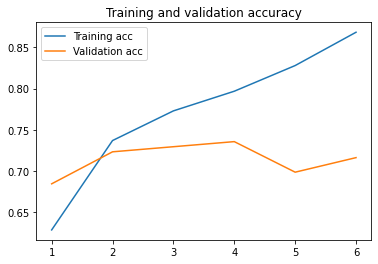

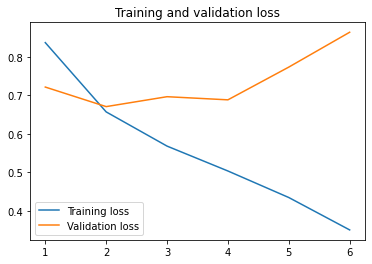

In [72]:
import matplotlib.pyplot as plt

acc = lstmcnn.history['accuracy']
val_acc = lstmcnn.history['val_accuracy']
loss = lstmcnn.history['loss']
val_loss = lstmcnn.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#Testing the Model

In [74]:
test_data = pd.read_csv('test.csv')
print(test_data.shape)
test_data.head(2)

(1418, 13)


,Unnamed: 0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,223,5.696408e+17,positive,0.3611,NaN,0.0,American,lmaxwell11,0,@AmericanAir Haha I had a boarding pass for 12...,2015-02-22 15:32:16 -0800,40.754700,-73.98380
1,18,5.685837e+17,positive,1.0000,NaN,NaN,Delta,sportsguy44,0,@JetBlue safety first !! #lovejetblue,2015-02-19 17:31:41 -0800,32.125726,-102.13789


In [79]:
X_test = test_data['text'].to_frame()
actualTweetsDF = test_data[['text']]
y = test_data['airline_sentiment'].to_frame()

We need to pre-process this test data before making predictions using the model

In [80]:
X_test['text'] = preProcessTweets(X_test,'text')
X_test.head(2)

100%|██████████| 1418/1418 [00:00<00:00, 16415.11it/s]


,text
0,haha boarding pass 12b boarding plane gate age...
1,safety first lovejetblue


In [87]:
tweets = X_test['text'].values
testTweets = [[i] for i in tweets]
print('ORIGINAL TEST TWEETS:')
print(testTweets[:5])
#looping through elements to tokenize and create padded sequence
for i in range(len(testTweets)):
  txt = testTweets[i]
  seq = tok.texts_to_sequences(txt)
  padded = pad_sequences(seq, maxlen=max_len,padding='post')
  testTweets[i] = padded
print('TOKENIZED & SEQUENCED TEST TWEETS:')
print(testTweets[:5])

ORIGINAL TEST TWEETS:
[['haha boarding pass 12b boarding plane gate agent told go 41g no worries'], ['safety first lovejetblue'], ['message pics sent'], ['flight arrives 30 minutes early wait hour bags'], ['no not notice 38a start boarding assumed 8e time boarding started gas cleared standbys full flt']]
TOKENIZED & SEQUENCED TEST TWEETS:
[array([[570, 127, 207, 127,  21,  31,  95, 113,  63,   8, 452,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=int32), array([[ 509,   62, 3123,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [93]:
#making predictions
labels = ['positive', 'negative','neutral']
conf = []
Label = []
for i in testTweets:
  pred = model.predict(i)
  Label.append(labels[np.argmax(pred)])
  conf.append(pred)
X_test['predicted'] = Label
X_test['actual'] = y.airline_sentiment
X_test['confVal'] = conf
X_test.head(2)


,text,predicted,actual,confVal
0,haha boarding pass 12b boarding plane gate age...,negative,positive,"[[0.0022133023, 0.9949993, 0.002787383]]"
1,safety first lovejetblue,neutral,positive,"[[0.08555761, 0.06153545, 0.8529069]]"


In [94]:
X_test.head(10)

,text,predicted,actual,confVal
0,haha boarding pass 12b boarding plane gate age...,negative,positive,"[[0.0022133023, 0.9949993, 0.002787383]]"
1,safety first lovejetblue,neutral,positive,"[[0.08555761, 0.06153545, 0.8529069]]"
2,message pics sent,neutral,neutral,"[[0.050127015, 0.12716217, 0.8227108]]"
3,flight arrives 30 minutes early wait hour bags,negative,negative,"[[7.174482e-05, 0.99950397, 0.00042435143]]"
4,no not notice 38a start boarding assumed 8e ti...,negative,neutral,"[[0.004659409, 0.86213887, 0.13320169]]"
5,terry hero got husband back thru security retr...,positive,positive,"[[0.46783245, 0.07071536, 0.46145216]]"
6,today going day feel thank support throughout ...,positive,neutral,"[[0.96847826, 0.00024325211, 0.031278484]]"
7,flying united sorry captain still 20 minutes p...,negative,negative,"[[0.0020482768, 0.9898885, 0.008063243]]"
8,clients got zero 32 years career never thought...,negative,negative,"[[0.008910775, 0.6394919, 0.35159734]]"
9,no late flight bag check lost business missed ...,negative,negative,"[[0.0017080429, 0.9844508, 0.013841186]]"


#Model evaluation

In [96]:
y['LABEL'] = 0
y.loc[y.airline_sentiment == 'positive', 'LABEL'] = 0
y.loc[y.airline_sentiment == 'negative', 'LABEL'] = 1
y.loc[y.airline_sentiment == 'neutral', 'LABEL'] = 2
print(y['LABEL'][:10])

0    0
1    0
2    2
3    1
4    2
5    0
6    2
7    1
8    1
9    1
Name: LABEL, dtype: int64


In [97]:
y_test = to_categorical(y['LABEL'], num_classes=3)
print(y_test[:10])

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [129]:
y_test.tolist()

[[1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 1.0, 0.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [1.0, 0.0, 0.0],
 [0.0, 0.0, 1.0],
 [0.0, 0.0, 1.0],
 [0.0, 1.0, 0.0],
 [1.0, 0.0

In [133]:
for i in range(len(X_test)):
  X_test['confVal'][i] = X_test['confVal'][i].flatten()

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(model, pred, y_test):
    
    sentiment_classes = ['positive', 'negative', 'neutral']
    # use model to do the prediction
    y_pred = model.predict(pred)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    return cm
    
cm = plot_confusion_matrix(model, y_train, y_test)

ValueError: ignored

In [ ]:
cm

array([[ 302,   81,   76],
       [  60, 1624,  205],
       [  59,  204,  317]])

In [ ]:
print('Prediction Accuracy: ')
print('Accuracy of Positive class in % : ')
print((cm[0][0]/(cm[0][0]+cm[0][1]+cm[0][2]))*100)
print('Accuracy of Negative class in %: ')
print((cm[1][1]/(cm[1][1]+cm[1][0]+cm[1][2]))*100)
print('Accuracy of Neutral class in %')
print((cm[2][2]/(cm[2][2]+cm[2][0]+cm[2][1]))*100)

Prediction Accuracy: 
Accuracy of Positive class in % : 
65.79520697167756
Accuracy of Negative class in %: 
85.97141344626786
Accuracy of Neutral class in %
54.65517241379311
